In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
goog_data = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)
goog_data = goog_data.loc['2014-01-01':'2018-01-01']

In [3]:
goog_data_signal = pd.DataFrame(index=goog_data.index)
goog_data_signal['price'] = goog_data['Adj Close']

Strategy Implementation

In [7]:
def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support = 0
    in_resistance = 0

    for x in range((bin_width-1) + bin_width, len(data)):
        data_section = data[x-bin_width:x+1]
        support_level = min(data_section['price'])
        resistance_level = max(data_section['price'])
        range_level = resistance_level - support_level
        data['sup'][x] = support_level
        data['res'][x] = resistance_level
        data['sup_tolerance'][x] = support_level + 0.2 * range_level
        data['res_tolerance'][x] = resistance_level - 0.2 * range_level

        if data['price'][x] >= data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance += 1
            data['res_count'][x] = in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and data['price'][x] >= data['sup'][x]:
            in_support += 1
            data['sup_count'][x] = in_support
        else:
            in_support = 0
            in_resistance = 0

        if in_resistance>2:
            data['signal'][x] = 1
        elif in_support>2:
            data['signal'][x] = 0
        else:
            data['signal'][x] = data['signal'][x-1]
        
    data['positions'] = data['signal'].diff()
    data.to_csv('Data.csv')

#Calling the function
trading_support_resistance(goog_data_signal)

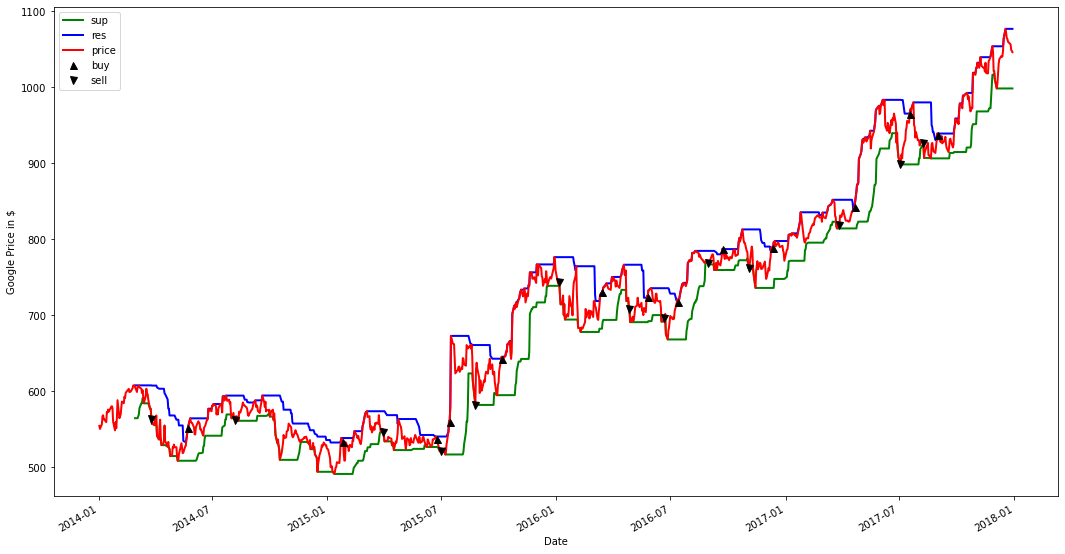

In [9]:
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111, ylabel='Google Price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,\
            goog_data_signal.price[goog_data_signal.positions == 1.0],
            '^', markersize=7, color='k', label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,\
            goog_data_signal.price[goog_data_signal.positions == -1.0],
            'v', markersize=7, color='k', label='sell')
plt.savefig('graph',facecolor='w', dpi=1000)
plt.legend()